# Blood Smears Classification

We'll compare the performance of a dense neural network and of a convolutional neural network for the classification of blood smears in the Malaria dataset.

In [82]:
import sys
sys.path.insert(0, "../../../")

## Load Data

We'll load and uncompress the single cell dataset from 
https://lhncbc.nlm.nih.gov/LHC-research/LHC-projects/image-processing/malaria-datasheet.html

In [83]:
import torch
import torchvision
from torchvision.datasets.utils import download_url, _extract_zip
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# dataset_url = "https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip"
# download_url(dataset_url, '../../data')
# _extract_zip("../../data/cell_images.zip","../../data/",None)

We'll define the path to the directories containing the `Infected` and `Parasitized` images.

In [84]:
import os
import glob
base_dir = os.path.join("../../data/cell_images/")
uninfected_files = glob.glob(base_dir+"Uninfected"+"/*.png")
infected_files = glob.glob(base_dir+"Parasitized"+"/*.png")

## Visualize Data

We'll then visualize some of the data.

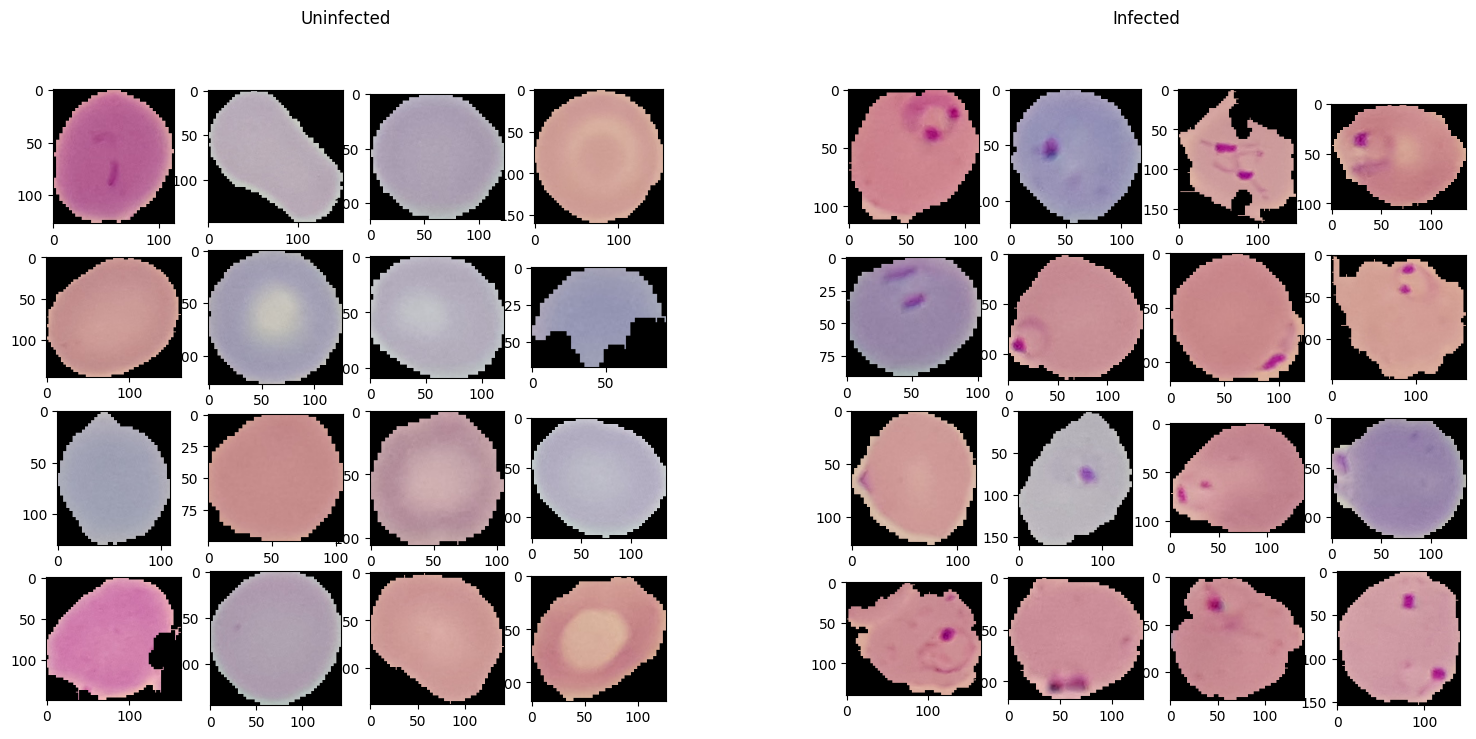

In [85]:
from plotting import plot_examples
plot_examples(uninfected_files,infected_files)

## Data Preprocessing

We'll define a popeline to resize and normalize the data ...

In [86]:
import torchvision.transforms as tt

pipeline = tt.Compose([tt.Resize((28,28)),
    tt.ToTensor()]) # automatically converts images to [0,1]


... subset the full dataset and split it into `train` and `test` sets ...

In [88]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Lambda
from torch.utils.data import random_split, Subset

#dataset = ImageFolder(base_dir, pipeline, target_transform= Lambda(lambda y: torch.nn.functional.one_hot(torch.tensor(y),2).float()))
dataset = ImageFolder(base_dir, pipeline, target_transform= Lambda(lambda y: torch.tensor(abs(-y)).float().unsqueeze(-1)))
print(dataset.class_to_idx)

subset_size = 5000
subset_indices = torch.randperm(len(dataset))[:subset_size]
subset = Subset(dataset, subset_indices)

train_size = int(0.8 * len(subset))
test_size = len(subset) - train_size
train, test = random_split(subset, [train_size, test_size])

{'Parasitized': 0, 'Uninfected': 1}


... and define the dataloaders for both sets. For the training, we'll set `batch_size = 32`.

In [89]:
from torch.utils.data import DataLoader
batch_size = 32
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size * 5, shuffle=False)

## Fully-connected Neural Network

We'll define a Fully-connected Neural Network (FCNN) using `deeplay`. The FCNN has 2 layers with 128 features.

In [90]:
import deeplay as dl

FCNN_config = (
    dl.Config()
    .in_features(28 * 28 * 3)
    .hidden_dims([128, 128])
    .out_features(1)
    .out_activation(torch.nn.Sigmoid)
)

FCNN = dl.MultiLayerPerceptron.from_config(FCNN_config)
print(FCNN)
# FCNN(torch.zeros(3,3,28,28)).shape

MultiLayerPerceptron(
  (in_features): 2352
  (hidden_dims): [128, 128]
  (out_features): 1
  (blocks): ModuleList(
    (0): Template(
      (layer): Linear(in_features=2352, out_features=128, bias=True)
      (normalization): Identity()
      (activation): ReLU()
      (dropout): Identity()
    )
    (1): Template(
      (layer): Linear(in_features=128, out_features=128, bias=True)
      (normalization): Identity()
      (activation): ReLU()
      (dropout): Identity()
    )
  )
  (out_layer): Linear(in_features=128, out_features=1, bias=True)
  (out_activation): Sigmoid()
)


We'll define a classifier based on the FCNN architecture, including loss function, evaluation metrics and othe hyperparameters ...

In [91]:
import torchmetrics as tm
FCNN_classifier_config = (
    dl.Config()
    .model(FCNN)
    .make_target_onehot(False)
    .loss(torch.nn.BCELoss)
    .train_metrics[0]( tm.Accuracy , task="binary")
    .train_metrics[1]( tm.Precision, task="binary" )
    .train_metrics[2]( tm.Recall, task="binary" )
    .val_metrics[0]( tm.Accuracy , task="binary")
    .val_metrics[1]( tm.Precision, task="binary" )
    .val_metrics[2]( tm.Recall, task="binary" )
    .optimizer(torch.optim.RMSprop, lr=0.001 )
    .optimizer.zero_grads()
)

FCNN_classifier = dl.Classifier.from_config(FCNN_classifier_config)
print(FCNN_classifier)

Classifier(
  (make_target_onehot): False
  (model): MultiLayerPerceptron(
    (in_features): 2352
    (hidden_dims): [128, 128]
    (out_features): 1
    (blocks): ModuleList(
      (0): Template(
        (layer): Linear(in_features=2352, out_features=128, bias=True)
        (normalization): Identity()
        (activation): ReLU()
        (dropout): Identity()
      )
      (1): Template(
        (layer): Linear(in_features=128, out_features=128, bias=True)
        (normalization): Identity()
        (activation): ReLU()
        (dropout): Identity()
      )
    )
    (out_layer): Linear(in_features=128, out_features=1, bias=True)
    (out_activation): Sigmoid()
  )
  (loss): BCELoss()
  (train_metrics): ModuleList(
    (0): BinaryAccuracy()
    (1): BinaryPrecision()
    (2): BinaryRecall()
  )
  (val_metrics): ModuleList(
    (0): BinaryAccuracy()
    (1): BinaryPrecision()
    (2): BinaryRecall()
  )
)


... and a trainer including other hyperparameters ...

In [92]:
FCNN_trainer = dl.Trainer(
    max_epochs=20, # How many times to run through the entire dataset
    accelerator="auto", # Use GPU if available
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


We'll start the training and visualize the evaluation metrics.

In [93]:
FCNN_trainer.fit(FCNN_classifier, train_loader)

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type                 | Params
-------------------------------------------------------
0 | model         | MultiLayerPerceptron | 317 K 
1 | loss          | BCELoss              | 0     
2 | train_metrics | ModuleList           | 0     
3 | val_metrics   | ModuleList           | 0     
-------------------------------------------------------
317 K     Trainable params
0         Non-trainable params
317 K     Total params
1.271     Total estimated model params size (MB)
/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` t

Training: |          | 0/? [00:00<?, ?it/s]

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


We'll calculate the performance over the test set.

In [94]:
_ = FCNN_trainer.test(FCNN_classifier, test_loader)

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   test_BinaryAccuracy      0.5580000281333923
  test_BinaryPrecision      0.5307881832122803
    test_BinaryRecall       0.8760162591934204
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## ROC curve and AUC
We'll use the function `plot_ROC_AUC` to get the ground truth and predictions for all the images in the test set, calculate the ROC and AUC, and visualize the results.
```python
def plot_ROC_AUC(classifier, dataset):
    from torch import tensor, stack
    from sklearn.metrics import roc_curve, auc
    from matplotlib import pyplot as plt

    im, gt = zip(*dataset)
    pred = classifier(tensor(stack(im))).tolist()
    # calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(gt, pred, pos_label=1) 
    roc_auc = auc(fpr, tpr) 

    # plot the ROC curve
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})", linewidth=2)
    plt.title("ROC curve")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.axis("square")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend(loc = 'center right')
    plt.show()

    return im, gt, pred, roc_auc
```

/Users/841602/Documents/GitHub/DeepLearningCrashCourse/Ch03_CNN_image_analysis/Appl01/plotting.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = classifier(tensor(stack(im))).tolist()


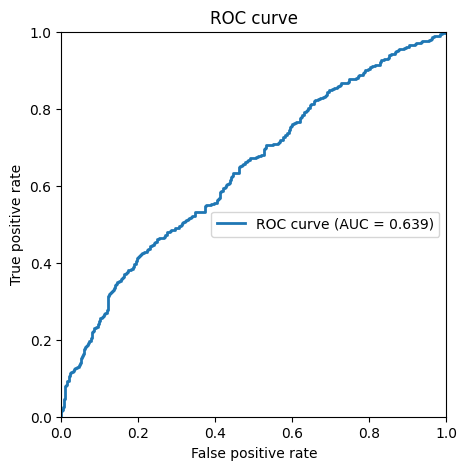

In [95]:
from plotting import plot_ROC_AUC
_,_,_,_ = plot_ROC_AUC(FCNN_classifier, test)

## Convolutional Neural Network with a dense top
We'll now build a convolutional neural network (CNN) with a FCNN at the end ...


In [96]:
dense_top = (
    dl.Layer("layer") >> dl.Layer("activation")
)

CNN_config = (
    dl.Config()
    .depth(4)
    .in_features(3)
    .input_block.layer.out_channels(32)
    .encoder_blocks[0].layer.out_channels(32)
    .encoder_blocks[0].pool(torch.nn.Identity)
    .encoder_blocks[1].layer.out_channels(64)
    .encoder_blocks[2].pool(torch.nn.Identity)
    .encoder_blocks[2].layer.out_channels(64)
    .encoder_blocks[3].pool(torch.nn.AdaptiveAvgPool2d((1)))
    .encoder_blocks[3].layer(torch.nn.Flatten)
    .encoder_blocks[3].activation(torch.nn.Identity)
    .output_block(dense_top)
#    .encoder_blocks[1].layer(torch.nn.LazyLinear,out_features=1)
    # .encoder_blocks[1].activation(torch.nn.Sigmoid)
    .output_block.layer(torch.nn.LazyLinear,out_features = 1)
    .output_block.activation(torch.nn.Sigmoid)
)#

CNN = dl.ImageToVectorEncoder.from_config(CNN_config)
_ = CNN(torch.zeros(batch_size, 3, 28, 28))

print(CNN)

ImageToVectorEncoder(
  (depth): 4
  (input_block): Template(
    (layer): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): ReLU()
  )
  (encoder_blocks): ModuleList(
    (0): Template(
      (pool): Identity()
      (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
    )
    (1): Template(
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
    )
    (2): Template(
      (pool): Identity()
      (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
    )
    (3): Template(
      (pool): AdaptiveAvgPool2d(output_size=1)
      (layer): Flatten(start_dim=1, end_dim=-1)
      (activation): Identity()
    )
  )
  (output_block): Template(
    (layer): Linear(in_features=64, out_features=1, bias=True)
    (activation

... define a classifier using the CNN ...

In [97]:
CNN_classifier_config = (
    dl.Config()
    .model(CNN)
    .make_target_onehot(False)
    .loss(torch.nn.BCELoss)
    .train_metrics[0]( tm.Accuracy, task="binary")
    .train_metrics[1]( tm.Precision, task="binary")
    .train_metrics[2]( tm.Recall, task="binary")
    .val_metrics[0]( tm.Accuracy, task="binary")
    .val_metrics[1]( tm.Precision, task="binary")
    .val_metrics[2]( tm.Recall, task="binary")
    .optimizer(torch.optim.RMSprop, lr=0.001)
    .optimizer.zero_grad()
)

CNN_classifier = dl.Classifier.from_config(CNN_classifier_config)
print(CNN_classifier)

Classifier(
  (make_target_onehot): False
  (model): ImageToVectorEncoder(
    (depth): 4
    (input_block): Template(
      (layer): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
    )
    (encoder_blocks): ModuleList(
      (0): Template(
        (pool): Identity()
        (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (1): Template(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (2): Template(
        (pool): Identity()
        (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (3): Template(
        (pool): AdaptiveAvgPool2d(output_size=1)
        (layer): Flatten(start_dim=1, end_dim=-1)
        (activation): Identity()
      )
    )

... train it ...

In [98]:
CNN_trainer = dl.Trainer(
    max_epochs=20, # How many times to run through the entire dataset
    accelerator="auto", # Use GPU if available
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [99]:
CNN_trainer.fit(CNN_classifier, train_loader)

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type                 | Params
-------------------------------------------------------
0 | model         | ImageToVectorEncoder | 65.6 K
1 | loss          | BCELoss              | 0     
2 | train_metrics | ModuleList           | 0     
3 | val_metrics   | ModuleList           | 0     
-------------------------------------------------------
65.6 K    Trainable params
0         Non-trainable params
65.6 K    Total params
0.263     Total estimated model params size (MB)
/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` t

Training: |          | 0/? [00:00<?, ?it/s]

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


... evaluate the performance over the test set ...

In [100]:
_ = CNN_trainer.test(CNN_classifier, test_loader)

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   test_BinaryAccuracy      0.5690000057220459
  test_BinaryPrecision      0.6205533742904663
    test_BinaryRecall       0.31910568475723267
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


... and display the ROC curve with the AUC value.

/Users/841602/Documents/GitHub/DeepLearningCrashCourse/Ch03_CNN_image_analysis/Appl01/plotting.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = classifier(tensor(stack(im))).tolist()


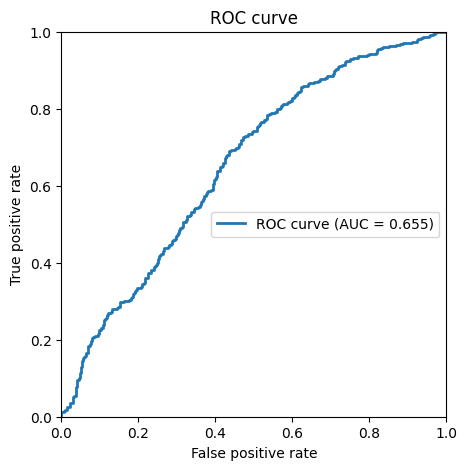

In [104]:
images, gt, pred, _ = plot_ROC_AUC(CNN_classifier, test)

## Failure analysis
We'll use a function to visualize some of the wrongly classified cells, looking for common patterns.
```python
def plot_failure(images, gt, pred, threshold = 0.5, num_of_plots = 5):
    from matplotlib import pyplot as plt 
    from numpy import array, squeeze   
    
    pred = array(pred).squeeze()
    gt = array(gt).squeeze()
    images = array(images)

    pred_class = pred > threshold

    false_positives = (pred_class == 1) & (gt == 0)
    false_positives_images = images[false_positives]

    false_negatives = (pred_class == 0) & (gt == 1)
    false_negatives_images = images[false_negatives]

    plt.figure(figsize=(num_of_plots*2, 5))
    for i in range(num_of_plots):
        # false positives
        plt.subplot(2, num_of_plots, i + 1)
        plt.imshow(false_positives_images[i].transpose(1, 2, 0))
        if i == 0:
            plt.title("False positives", fontsize=16, y=1.1)

        # false negatives
        plt.subplot(2, num_of_plots, i + num_of_plots + 1)
        plt.imshow(false_negatives_images[i].transpose(1, 2, 0))
        if i == 0:
            plt.title("False negatives", fontsize=16, y=1.1)

    plt.tight_layout()
    plt.show()
    ```

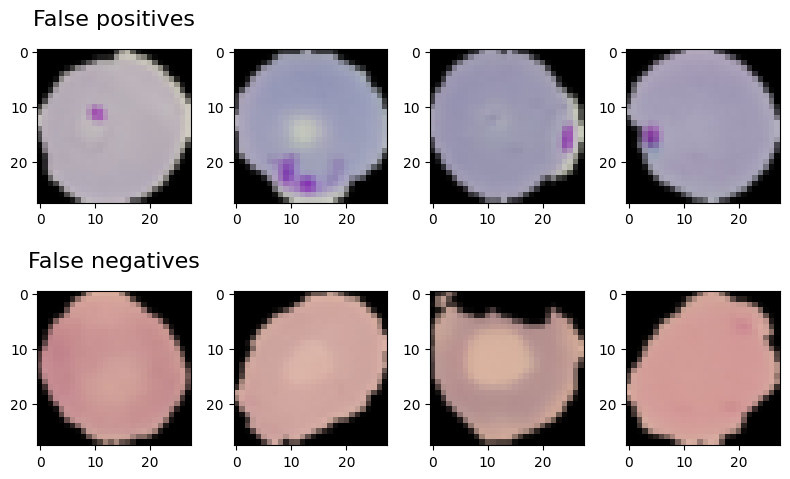

In [114]:
from plotting import plot_failure
plot_failure(images, gt, pred, threshold = 0.5, num_of_plots = 4)

## Filters
We can access and visualize the filters used by the network at a specific layer.

In [134]:
def plot_filters_activations(tensor,n_rows, normalize = True):
    from matplotlib import pyplot as plt
    fig,axes = plt.subplots(n_rows, tensor.shape[0]//n_rows, figsize=(2*tensor.shape[0]//n_rows,2*n_rows))
    for i in range(tensor.shape[0]):
        p  = tensor[i].permute(1,2,0)
        if normalize: 
            p /= p.max((1,2))
    axes.ravel()[i].axis('off')
    axes.ravel()[i].imshow(p, interpolation = 'bilinear')
    axes.ravel()[i].set_title(i)
    fig.suptitle('Filters', fontsize = 16)
    fig.tight_layout()
    plt.show()

    

TypeError: max() received an invalid combination of arguments - got (tuple), but expected one of:
 * ()
      didn't match because some of the arguments have invalid types: (!tuple of (int, int)!)
 * (Tensor other)
      didn't match because some of the arguments have invalid types: (!tuple of (int, int)!)
 * (int dim, bool keepdim)
 * (name dim, bool keepdim)


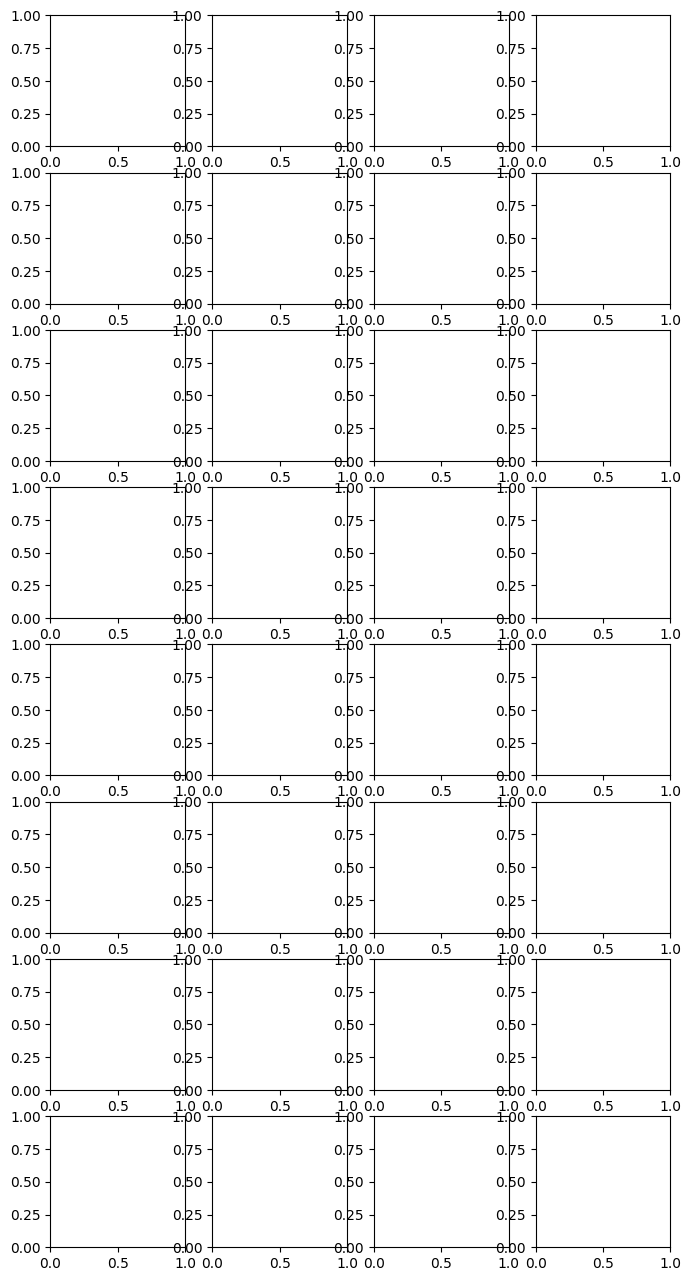

In [135]:
weights = CNN.input_block.layer.weight
w = weights.clone().detach()

plot_filters_activations(w,8)

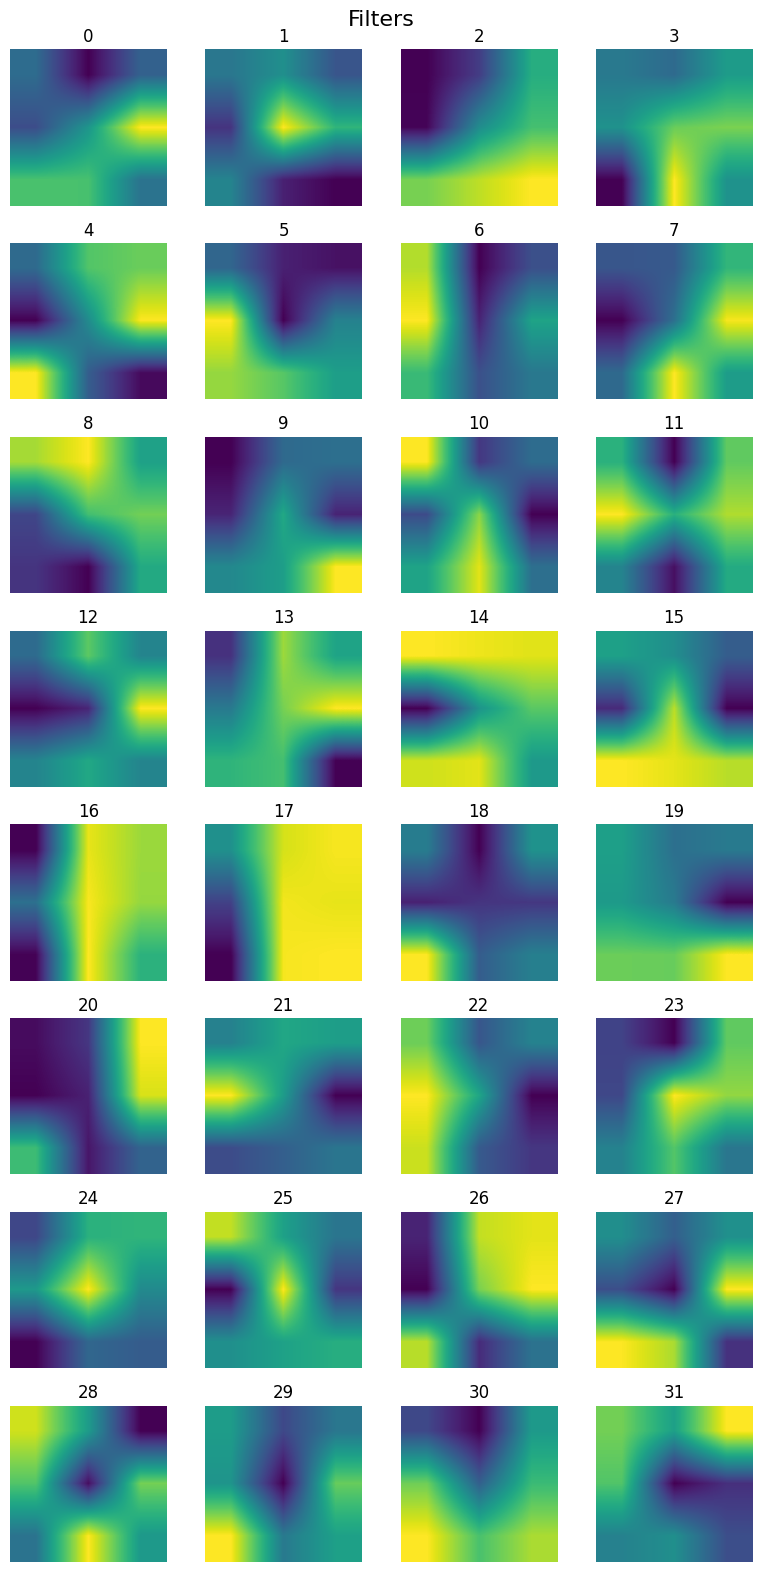

In [250]:

fig,axes = plt.subplots(8, 4, figsize=(8,16))
for i in range(32):
    axes.ravel()[i].axis('off')
    axes.ravel()[i].imshow(weights[i].permute(1,2,0).clone().detach()[:,:,1], interpolation = 'bilinear')
    axes.ravel()[i].set_title(i)
fig.suptitle('Filters', fontsize = 16)
fig.tight_layout()
plt.show()

## Activations and Grad-CAM
To visualize the network feautures, we'll use `hooks`, functions that allows us to access the information that the model sees during forward and backward passes, such as activations and gradients, respectively. We'll define them as context manager classes, so that we can use them with the `with` statement:
```python
class fwd_hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o):
        print('Forward hook running...') 
        self.stored = o.detach().clone()
        print(f'Activations size: {self.stored.size()}')
    def __enter__(self, *args): 
        return self
    def __exit__(self, *args): 
        self.hook.remove()


class bwd_hook():
    def __init__(self, m):
        self.hook = m.register_full_backward_hook(self.hook_func)
    def hook_func(self, m, gi, go):
        print('Backward hook running...')
        self.stored = go[0].detach().clone()
        print(f'Gradients size: {self.stored.size()}') 
    def __enter__(self, *args): 
        return self
    def __exit__(self, *args): 
        self.hook.remove()
```

Activations and gradients can be obtained from the forward and backward pass, respectively ...

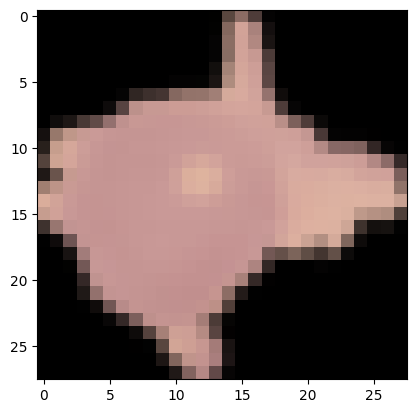

In [277]:
img, _ = next(iter(test_loader))
img_hr = test.dataset[0][0]
lab = test.dataset[0][1]
test.indices
my_image = img[0].unsqueeze(0)
plt.imshow(img_hr.permute(1,2,0))
#plt.imshow(my_image[0].permute(1,2,0))


In [253]:
# img, _ = next(iter(test_loader))

my_image = img[10].unsqueeze(0)
my_layer = CNN.encoder_blocks[-2].layer

from hooks import fwd_hook, bwd_hook
with bwd_hook(my_layer) as bh:
    with fwd_hook(my_layer) as fh:
        out = CNN(my_image).backward()
activations = fh.stored
gradients = bh.stored

Forward hook running...
Activations size: torch.Size([1, 64, 14, 14])
Backward hook running...
Gradients size: torch.Size([1, 64, 14, 14])


... we can plot the activations ...

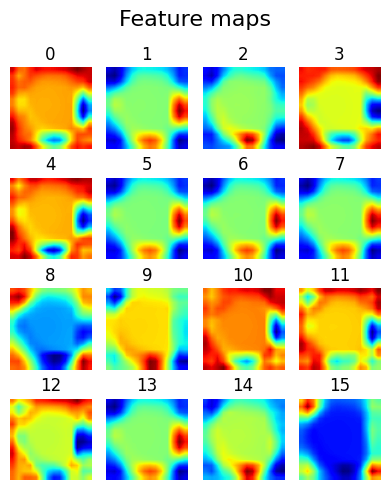

In [254]:
from matplotlib import pyplot as plt
fig,axes = plt.subplots(4, 4, figsize=(4,5))
for i in range(16):
    axes.ravel()[i].imshow(activations[0][i], interpolation='bilinear', cmap = 'jet')
    axes.ravel()[i].axis('off')
    axes.ravel()[i].set_title(i)
fig.suptitle('Feature maps', fontsize = 16)
fig.tight_layout()
plt.show()

... or combine gradients and activations to calculate Grad-CAM and inspect on which part of an image the CNN focuses to predict its outputs. 

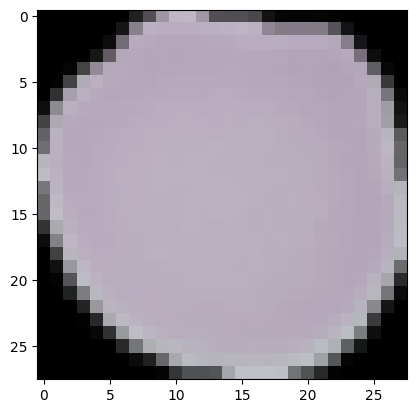

In [257]:
w = gradients[0].mean(dim=[1,2], keepdim = True)
grad_cam = torch.nn.functional.relu((w*activations[0]).sum(0))
plt.imshow(my_image[0].permute(1,2,0))
#plt.imshow((grad_cam.detach()),interpolation = 'bilinear',extent = (0,28,28,0), cmap = 'jet', alpha= 0.7)

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

# weight the channels by corresponding gradients
for i in range(acts.size()[1]):
    acts[:, i, :, :] *= pooled_grads[i]

# average the channels of the activations
heatmap = torch.mean(acts, dim=1).squeeze()

# relu on top of the heatmap
heatmap = F.relu(heatmap)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.detach())

In [ ]:
classifier.eval()
img, _ = next(iter(test_loader))

# get the most likely prediction of the model
pred = classifier(img)

In [ ]:
pred[0:5]

In [ ]:
CNN.encoder_blocks[-1]

In [ ]:
# defines two global scope variables to store our gradients and activations
gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
  global gradients # refers to the variable in the global scope
  print('Backward hook running...')
  gradients = grad_output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Gradients size: {gradients[0].size()}') 
  # We need the 0 index because the tensor containing the gradients comes
  # inside a one element tuple.

def forward_hook(module, args, output):
  global activations # refers to the variable in the global scope
  print('Forward hook running...')
  activations = output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Activations size: {activations.size()}')

In [ ]:
backward_hook = CNN.encoder_blocks[-1].register_full_backward_hook(backward_hook, prepend=False)
forward_hook = CNN.encoder_blocks[-1].register_forward_hook(forward_hook, prepend=False)

In [ ]:
CNN(img[0].unsqueeze(0)).backward()

In [ ]:
pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])


In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

# weight the channels by corresponding gradients
for i in range(activations.size()[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
heatmap = F.relu(heatmap)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.detach())

In [ ]:
# # get the gradient of the output with respect to the parameters of the model
# pred[0].backward()

# pull the gradients out of the model
gradients = CNN.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = classifier.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [ ]:
CNN

In [ ]:
mps_device = torch.device("mps")
model = classifier
model.to(mps_device)


In [ ]:
from tqdm import tqdm
@torch.no_grad()
# def evaluate(model, val_loader):
#     model.eval()
#     outputs = [model.validation_step(batch) for batch in val_loader]
#     return model.validation_epoch_end(outputs)

def tqdm_enumerate(iter):
    i = 0
    for y in tqdm(iter):
        yield i, y
        i += 1

def fit(epochs, lr, model, train_loader, device, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for i,batch in tqdm_enumerate(train_loader):
            batch = [ batch[0].to(device), batch[1].to(device)]
            loss = model.training_step(batch, i)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = [] #evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
# model=classifier()
# model.to(device)
num_epochs = 2
opt_func = torch.optim.Adam
learning_rate = 1e-2
history = fit(5, 0.001, model, train_loader, mps_device)